### **Practical Quantum Computational Advantage**

Quantum computers hold the promise of performing tasks that are fundamentally beyond the reach of classical machines. However, leveraging algorithms such as Shor's algorithm requires fault-tolerant quantum computing through error correction, which is not yet achievable with current devices. This raises a critical question in the field: can the noisy intermediate-scale quantum (NISQ) devices available today already provide meaningful computational advantages or outperform classical methods for certain practical problems? Recent developments suggest that this goal is within reach. In particular, a recent study by IBM demonstrates that their 127-qubit processor, ibm_kyiv, with exceptionally long coherence times, can faithfully simulate the time evolution of complex quantum many-body systems. One of the key accomplishments of this work is the successful application of **error mitigation techniques** using a learned noise model, showing that even in the presence of significant noise and reasonably deep quantum circuits, reliable and accurate results can be obtained. This represents an important step toward realizing practically useful quantum computations and illustrates that current devices, when combined with advanced noise management strategies, can already tackle problems that challenge classical approaches.


### **Problem**   

Before delving into the discussion of error suppression techniques, let us first outline the computational task under consideration. The study in [1] deals with the simulation of the real-time dynamics of a **two-dimensional transverse field Ising Hamiltonian**, given as
$$
\mathcal{H} = -K \sum_{\langle i,j \rangle} Z_{i}Z_{j} + g \sum_{i} X_{i},
$$  
where the summation $\langle i,j \rangle$ denotes interactions only between nearest-neighbor sites. Here, $K$ represents the ferromagnetic coupling constant and $g$ corresponds to the transverse field strength. The time evolution under this Hamiltonian is implemented approximately by **Trotterization** of the exponential operator:  
$$
U(\tau) \approx \Bigg(\prod_{\langle i,j \rangle} e^{\;i \Delta \tau K Z_{i}Z_{j}} \; \prod_{i} e^{-i \Delta \tau g X_{i}} \Bigg)^{\tau / \Delta \tau},
$$  
for a chosen total evolution time $\tau$ and a Trotter step size $\Delta \tau$. This results in a quantum circuit composed of sequential two-qubit $R_{ZZ}(\phi_{K})$ rotations and single-qubit $R_{X}(\phi_{g})$ rotations, with the gate parameters connected to the physical model as follows:  

$$
\phi_{K} = -2K \Delta \tau,
$$  

$$
\phi_{g} = 2g \Delta \tau.
$$  

For simplicity in later sections, we will concentrate exclusively on the parameter $\phi_{g}$ while fixing $\phi_{K} = -\pi/2$. This specific choice is motivated by the fact that it reduces the complexity of the circuit decomposition into the native CNOT gates of the hardware.


### Simulation with Noise  

When analyzing the dynamics of the circuit, the difficulty of performing a classical simulation is governed by the parameter $\phi_{g}$. At the special points $\phi_{g} = 0$ and $\phi_{g} = \pi/2$, the model simplifies to cases that can be solved directly without requiring heavy computation. To explore the non-trivial region between these two limits, we track the behavior of a local observable, specifically $\langle Z_{4} \rangle$. Since the actual device involves 127 qubits, simulating the full system is out of reach on a classical machine. Instead, we restrict ourselves to a reduced model consisting of only 9 qubits arranged on a $3 \times 3$ square lattice, where couplings are only between nearest neighbors. This scaled-down setup still preserves the structure of the problem while remaining computationally manageable.  

To incorporate noise, we apply a **depolarizing channel** after each gate execution in the circuit. Intuitively, this channel describes the situation where, with total probability $p$, the qubit state is randomly perturbed by one of the Pauli operations $\{X, Y, Z\}$, each occurring with probability $p/3$. From a theoretical standpoint, this randomness can be described using Kraus operators, which capture the mixing of different quantum trajectories introduced by the noise. Because of this probabilistic blending of outcomes, the simulation cannot rely on a pure-state backend. Instead, a **mixed-state simulator** is required in order to correctly capture the effects of the depolarizing process on the system’s evolution.  


In [12]:
import pennylane as qml
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

n_wires = 9
# Describe noise
noise_gate = qml.DepolarizingChannel
p = 0.005

# Load devices
dev_ideal = qml.device("default.mixed", wires=n_wires)
dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, p, position="all")

# 3x3 grid with nearest neighbors
connections = [(0, 1), (1, 2),
               (3, 4), (4, 5),
               (6, 7), (7, 8),
               (0, 3), (3, 6),
               (1, 4), (4, 7),
               (2, 5), (5, 8)]

def time_evolution(theta_h, n_layers = 10, obs = qml.PauliZ(4)):
    for _ in range(n_layers):
        for i, j in connections:
            qml.IsingZZ(-jnp.pi/2, wires=(i, j))
        for i in range(n_wires):
            qml.RX(theta_h, wires=i)
    return qml.expval(obs)

qnode_ideal = qml.QNode(time_evolution, dev_ideal, interface="jax")
qnode_noisy = qml.QNode(time_evolution, dev_noisy, interface="jax")

In [ ]:
# import pennylane as qml
# import jax
# import jax.numpy as jnp
# import matplotlib.pyplot as plt
# jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')

# # ---------------------------
# # Grid and device setup
# # ---------------------------
# N = 3                  # grid size (5x5)
# n_wires = N * N        # total qubits = 25

# # Describe noise
# noise_gate = qml.DepolarizingChannel
# p = 0.005

# # Load devices
# dev_ideal = qml.device("lightning.qubit", wires=n_wires)
# dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, p, position="all")

# # ---------------------------
# # Define nearest-neighbor connections on 5x5 lattice
# # ---------------------------
# def idx(r, c, N):
#     """Row-major index for site (r, c)."""
#     return r * N + c

# connections = []
# for r in range(N):
#     for c in range(N):
#         w = idx(r, c, N)
#         if c + 1 < N:   # right neighbor
#             connections.append((w, idx(r, c+1, N)))
#         if r + 1 < N:   # down neighbor
#             connections.append((w, idx(r+1, c, N)))

# # ---------------------------
# # Circuit definition
# # ---------------------------
# def time_evolution(theta_h, n_layers=10, obs=qml.PauliZ(4)):
#     for _ in range(n_layers):
#         # ZZ interaction layer
#         for i, j in connections:
#             qml.IsingZZ(-jnp.pi/2, wires=(i, j))
#         # RX transverse-field layer
#         for i in range(n_wires):
#             qml.RX(theta_h, wires=i)
#     return qml.expval(obs)

# # ---------------------------
# # QNodes
# # ---------------------------
# qnode_ideal = qml.QNode(time_evolution, dev_ideal, interface="jax")
# qnode_noisy = qml.QNode(time_evolution, dev_noisy, interface="jax")
# print(connections)

[(0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (3, 4), (3, 6), (4, 5), (4, 7), (5, 8), (6, 7), (7, 8)]


We now simulate the expectation value of the observable with and without noise on the $4 \times 4$ lattice. Since the `IsingZZ` gate is not natively available on the `default.mixed` device, PennyLane automatically decomposes it into a supported gate set. After this decomposition, depolarizing noise channels are inserted following each gate, ensuring that the noise model acts consistently across the full circuit. To efficiently evaluate the observable over a range of transverse field angles $\theta_h$, we employ `jax.vmap`, which vectorizes the computations and significantly accelerates the evaluation process.

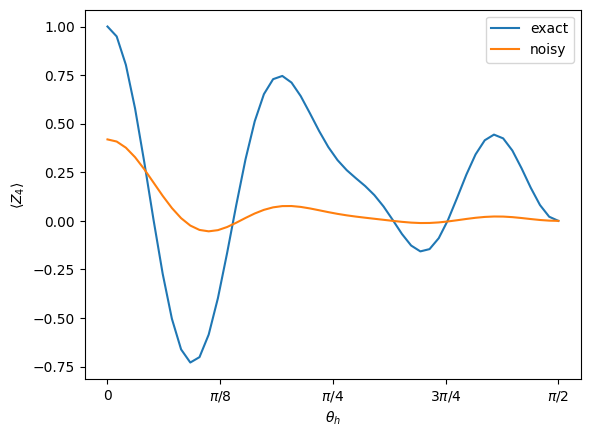

In [13]:
thetas = jnp.linspace(0, jnp.pi/2, 50)

res_ideal = jax.vmap(qnode_ideal)(thetas)
res_noisy = jax.vmap(qnode_noisy)(thetas)

plt.plot(thetas, res_ideal, label="exact")
plt.plot(thetas, res_noisy, label="noisy")
plt.xticks([0, jnp.pi/8, jnp.pi/4, 3*jnp.pi/8, jnp.pi/2], ["0", "$\\pi$/8", "$\\pi/4$", "$3\\pi/4$", "$\\pi/2$"])
plt.xlabel("$\\theta_h$")
plt.ylabel("$\\langle Z_4 \\rangle$")
plt.legend()
plt.show()

### **Error Mitigation with Zero Noise Extrapolation**  

To reduce the effects of hardware noise, we can implement an error mitigation technique known as **Zero Noise Extrapolation (ZNE)**. This approach allows us to recover more reliable expectation values by combining noisy quantum results with classical post-processing. The central idea is the following: suppose there exists an ideal function $F$ that represents the exact expectation value in the absence of noise. In practice, what is measured is a noisy approximation, denoted by $F'$. By introducing a **noise amplification parameter** $G$, we can systematically increase the noise level during circuit execution. The case $G=1$ corresponds to the natural noise of the device. We then evaluate $F'$ at several values of $G > 1$, which gives us a collection of results at progressively higher noise levels. From this dataset, we fit an appropriate curve and extrapolate backwards to $G=0$, the point corresponding to an ideal noiseless device. The extrapolated value provides a mitigated estimate of the true expectation value.  

To make this process possible, we need a method to scale the noise in our circuits. One common strategy is to deliberately extend the circuit depth—for instance, by replacing a gate with multiple equivalent copies—so that the logical operation is unchanged but the accumulated noise increases. In this way, we obtain the controllable knob required for zero noise extrapolation.


#### **Noise-Aware Zero Noise Extrapolation** 

A more advanced variant of ZNE can be carried out when we have an explicit model for the noise affecting the device. The general strategy is to first identify the parameters of a chosen noise model that characterizes the hardware. In principle, once such a model is available, one could attempt to cancel errors directly through probabilistic error cancellation. While this method is conceptually powerful, it typically leads to an exponential increase in the number of required samples, making it impractical for large systems. Instead of attempting full cancellation, we can use the information from the noise model to deliberately amplify the noise in a controlled manner. This creates the required family of noisy circuits for zero noise extrapolation. In our case, the setup is simpler because the noise process in the simulation is fully known and under complete control. This allows us to introduce a tunable **gain factor** $G$ that rescales the error probabilities of the noise channel. For demonstration, we can consider $G \in \{1.0, \, 1.2, \, 1.6\}$, where $G=1$ corresponds to the baseline noise level.  

Implementing this in PennyLane is straightforward: we define multiple noisy devices, each with adjusted noise parameters according to the chosen gain factors. Running the same circuit on these devices then produces the dataset required to carry out the extrapolation back to the zero-noise limit. 

In [ ]:
dev_noisy1 = qml.transforms.insert(dev_ideal, noise_gate, p*1.2, position="all")
dev_noisy2 = qml.transforms.insert(dev_ideal, noise_gate, p*1.6, position="all")

qnode_noisy1 = qml.QNode(time_evolution, dev_noisy1, interface="jax")
qnode_noisy2 = qml.QNode(time_evolution, dev_noisy2, interface="jax")

res_noisy1 = jax.vmap(qnode_noisy1)(thetas)
res_noisy2 = jax.vmap(qnode_noisy2)(thetas)

We can take these results and simply extrapolate back to G = 0 with a polynomial fit and plot the nosidy, exact and extrap